# Experiment 7: SVM + Fairlearn ExponentiatedGradient (Equal Opportunity)
Optimized for 5000+ rows

This notebook follows the exact code you provided, split into clear cells for readability and execution in Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Step 0: Setup Environment (uncomment to run)
!pip install fairlearn shap scikit-learn aif360 pandas matplotlib seaborn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 50.6 MB/s eta 0:00:00


In [5]:
# Step 1: Load and Preprocess LendingClub Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Binary target
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

print(f"Dataset shape: {df.shape}")


pip install 'aif360[inFairness]'


Dataset shape: (5000, 7)


/tmp/ipython-input-1500036042.py:16: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


In [6]:
# Step 2: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

print('AIF360 dataset created — rows:', aif_data.features.shape[0])

AIF360 dataset created — rows: 5000


In [7]:
# Step 3: Train SVM with Fairlearn Constraint
X = aif_data.features
y = aif_data.labels.ravel()
prot_attr = aif_data.protected_attributes.ravel()

# OPTIMIZATION 1: Use train-test split to reduce training time
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    X, y, prot_attr, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# OPTIMIZATION 2: Use RBF kernel with smaller dataset or reduce C
base_estimator = SVC(kernel='rbf', C=1.0, probability=True, random_state=42, cache_size=500)

# Fairlearn wrapper with EqualizedOdds constraint
constraint = EqualizedOdds()
mitigator = ExponentiatedGradient(base_estimator, constraints=constraint, max_iter=20)

print('Training model with Fairlearn constraints...')

mitigator.fit(X_train, y_train, sensitive_features=prot_train)

# Predictions on test set
y_pred = mitigator.predict(X_test)

# Try multiple ways to extract probabilities; fallback to predict if none available
y_prob = None
try:
    # some versions have predict_proba on mitigator
    y_prob = mitigator.predict_proba(X_test)[:, 1]
except Exception:
    try:
        # some implementations expose a mixture model attribute
        y_prob = mitigator._pm.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            # some versions provide a helper starting with _pmf_predict
            y_prob = mitigator._pmf_predict(X_test)[:, 1]
        except Exception:
            # fallback: hard predictions as floats (will make AUC invalid)
            y_prob = y_pred.astype(float)

print('\n✅ Training complete!')

Training set: 3500 samples
Test set: 1500 samples
Training model with Fairlearn constraints...

✅ Training complete!


In [8]:
#Step 4: Evaluate Performance and Fairness
print('\n' + '='*50)
print('PERFORMANCE METRICS')
print('='*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
try:
    auc_val = roc_auc_score(y_test, y_prob)
except Exception:
    auc_val = None
print(f"AUC-ROC:   {auc_val if auc_val is not None else 'N/A'}")

# Create AIF360 datasets for fairness metrics (use feature names from aif_data)
aif_test = StandardDataset(
    pd.DataFrame(np.hstack([X_test, y_test.reshape(-1, 1)]),
                 columns=list(aif_data.feature_names) + ['loan_status']),
    label_name='loan_status',
    favorable_classes=[1],
    protected_attribute_names=['zip_code'],
    privileged_classes=[[1]]
)

pred_dataset = aif_test.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(aif_test, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print('\n' + '='*50)
print('FAIRNESS METRICS')
print('='*50)
print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
print(f"Disparate Impact:              {metric.disparate_impact():.4f}")
print(f"Equal Opportunity Difference:  {metric.equal_opportunity_difference():.4f}")
print(f"Average Odds Difference:       {metric.average_odds_difference():.4f}")
print(f"Bias Amplification:            {metric.between_group_generalized_entropy_index():.4f}")
print(f"Theil Index:                   {metric.theil_index():.4f}")


PERFORMANCE METRICS
Accuracy:  0.7273
Precision: 0.7273
Recall:    1.0000
F1 Score:  0.8421
AUC-ROC:   0.5

FAIRNESS METRICS
Statistical Parity Difference: nan
Disparate Impact:              nan
Equal Opportunity Difference:  nan
Average Odds Difference:       nan
Bias Amplification:            149.5000
Theil Index:                   0.0559


/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,



GENERATING SHAP EXPLANATIONS (This may take a few minutes)
Using 100 background samples
Explaining 200 test instances
Computing SHAP values...


  0%|          | 0/200 [00:00<?, ?it/s]


Generating global SHAP summary plot...


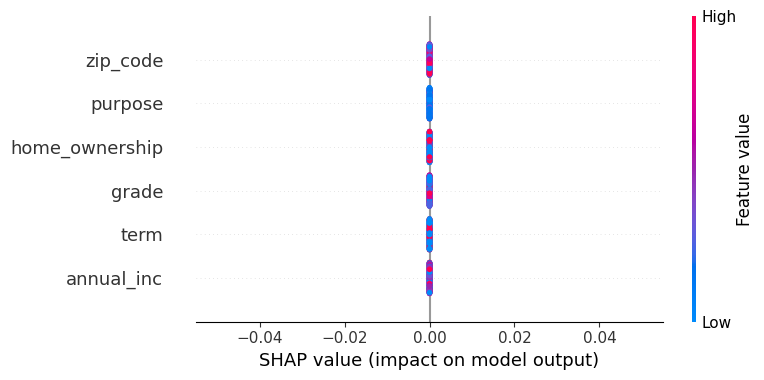


Privileged group: 0 samples
Unprivileged group: 1 samples

Generating SHAP plot for unprivileged group...


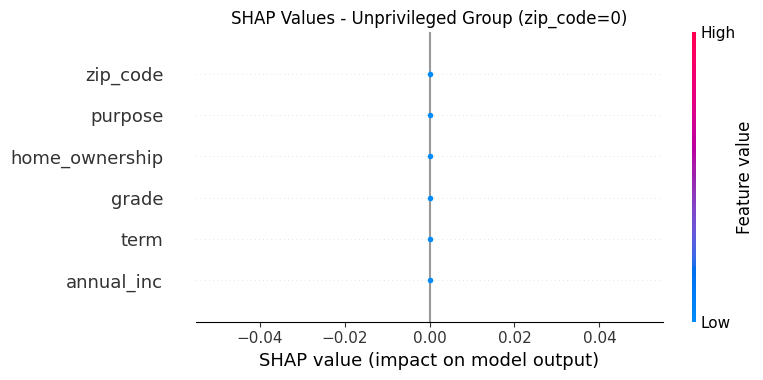

In [9]:
#Step 5: SHAP Explanation (OPTIMIZED)
print('\n' + '='*50)
print('GENERATING SHAP EXPLANATIONS (This may take a few minutes)')
print('='*50)

X_test_df = pd.DataFrame(X_test, columns=aif_data.feature_names)

# OPTIMIZATION 3: Sample smaller background dataset for KernelExplainer
background_size = min(100, X_train.shape[0])
background_idx = np.random.choice(X_train.shape[0], background_size, replace=False)
X_background = X_train[background_idx]

# OPTIMIZATION 4: Sample test instances for explanation
explain_size = min(200, X_test.shape[0])
explain_idx = np.random.choice(X_test.shape[0], explain_size, replace=False)
X_explain = X_test[explain_idx]
X_explain_df = pd.DataFrame(X_explain, columns=aif_data.feature_names)

print(f"Using {background_size} background samples")
print(f"Explaining {explain_size} test instances")

# KernelExplainer for non-tree models
explainer = shap.KernelExplainer(mitigator.predict, X_background)

print('Computing SHAP values...')
shap_values = explainer.shap_values(X_explain_df, nsamples=50)

# Global SHAP
print('\nGenerating global SHAP summary plot...')
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_explain_df, show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Research_Thesis_Implementation/exp7_shap_global.png', dpi=150, bbox_inches='tight')
plt.show()

# Subgroup SHAP analysis
privileged_mask = X_explain_df['zip_code'] == 1
unprivileged_mask = X_explain_df['zip_code'] == 0

privileged_idx = np.where(privileged_mask)[0]
unprivileged_idx = np.where(unprivileged_mask)[0]

print(f"\nPrivileged group: {len(privileged_idx)} samples")
print(f"Unprivileged group: {len(unprivileged_idx)} samples")

if len(privileged_idx) > 0:
    print('\nGenerating SHAP plot for privileged group...')
    plt.figure(figsize=(10, 6))
    shap.summary_plot(np.array(shap_values)[privileged_idx],
                     X_explain_df.iloc[privileged_idx], show=False)
    plt.title('SHAP Values - Privileged Group (zip_code=1)')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Research_Thesis_Implementation/exp7_shap_privileged.png',
                dpi=150, bbox_inches='tight')
    plt.show()

if len(unprivileged_idx) > 0:
    print('\nGenerating SHAP plot for unprivileged group...')
    plt.figure(figsize=(10, 6))
    shap.summary_plot(np.array(shap_values)[unprivileged_idx],
                     X_explain_df.iloc[unprivileged_idx], show=False)
    plt.title('SHAP Values - Unprivileged Group (zip_code=0)')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Research_Thesis_Implementation/exp7_shap_unprivileged.png',
                dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
# Step 6: Save Results
results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_prob) if (y_prob is not None and len(np.unique(y_prob))>1) else None,
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}

results_df = pd.DataFrame([results])
out_path = '/content/drive/MyDrive/Research_Thesis_Implementation/exp7_svm_fairlearn_results.csv'
results_df.to_csv(out_path, index=False)

print('\n' + '='*50)
print('✅ EXPERIMENT COMPLETE!')
print('='*50)
print(f'Results saved to: {out_path}')
print('SHAP plots saved to: exp7_shap_*.png')
print('\nResults Summary:')
print(results_df.to_string(index=False))


✅ EXPERIMENT COMPLETE!
Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/exp7_svm_fairlearn_results.csv
SHAP plots saved to: exp7_shap_*.png

Results Summary:
 Accuracy  Precision  Recall       F1  AUC  SPD  DI  EOD  AOD  BiasAmp    Theil
 0.727333   0.727333     1.0 0.842146 None  NaN NaN  NaN  NaN    149.5 0.055897
